# 1.0 Get and view data

In [47]:
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.sql.functions import (avg, col, count, datepart, date_format,
                                   expr, from_json, from_unixtime,
                                   from_utc_timestamp, hour, length, max, min,
                                   regexp_replace, sha2, split, sum, trim, when)
from pyspark.sql.types import StructType, StructField, StringType
from uszipcode import SearchEngine

In [2]:
data_path = os.path.join('..', 'data', 'cc_sample_transaction.json')
spark = SparkSession.builder.appName('CC Data Analysis').getOrCreate()
raw_cc_data = spark.read.json(data_path)
raw_cc_data.limit(5).show()  # Looking at the first 5 rows

+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|Unnamed: 0|   amt|     category|     cc_bic|          cc_num|is_fraud|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|            merchant|     personal_detail|trans_date_trans_time|           trans_num|
+----------+------+-------------+-----------+----------------+--------+----------------+----------------------+------------------+-----------+-------------+--------------------+--------------------+---------------------+--------------------+
|         0|  4.97|     misc_net|CITIUS33CHI|2703186189652095|       0|1325376018798532|         1325376018666|         36.011293| -82.048315|        28705|fraud_Rippin, Kub...|{"person_name":"J...|  2019-01-01 00:00:18|0b242abb623afc578...|
|         1|107.23|  grocery_pos

In [3]:
# Looking at the personal_detail column which will need to be parsed
raw_cc_data.select('personal_detail').limit(5).show(truncate=False)

+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|personal_detail                                                                                                                                                                                                                                                                      |
+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|{"person_name":"Jennifer,Banks,eeeee","gender":"F","address":"{\"street\":\"561 Perry Cove\",\"city\":\"Moravian Falls\",\"state\":\"NC\",\"zip\":\"28654\"}","

# 2.0 Data Transformation

## 2.1 Parse `personal_detail` column

In [4]:
transformed_cc_data = raw_cc_data.select('*')
address_schema = StructType([
    StructField('street', StringType(), True),
    StructField('city', StringType(), True),
    StructField('state', StringType(), True),
    StructField('zip', StringType(), True)
])

personal_details_schema = StructType([
    StructField('person_name', StringType(), True),
    StructField('gender', StringType(), True),
    StructField('address', StringType(), True),
    StructField('lat', StringType(), True),
    StructField('long', StringType(), True),
    StructField('city_pop', StringType(), True),
    StructField('job', StringType(), True),
    StructField('dob', StringType(), True)
])

transformed_cc_data = transformed_cc_data.withColumn(
    'personal_detail_parsed',
    from_json(col('personal_detail'), personal_details_schema))

transformed_cc_data = transformed_cc_data.withColumn(
    'address_parsed',
    from_json(col('personal_detail_parsed.address'), address_schema))

transformed_cc_data = transformed_cc_data.select(
    col('Unnamed: 0').alias('id'),
    col('amt').alias('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_date_trans_time'),
    col('cc_num'),
    col('personal_detail_parsed.person_name').alias('cc_owner'),
    col('personal_detail_parsed.gender').alias('gender'),
    col('personal_detail_parsed.job').alias('job'),
    col('personal_detail_parsed.dob').alias('date_of_birth'),
    col('address_parsed.street').alias('address_street'),
    col('address_parsed.city').alias('address_city'),
    col('address_parsed.state').alias('address_state'),
    col('address_parsed.zip').alias('address_zipcode'),
    col('personal_detail_parsed.lat').alias('cc_owner_lat'),
    col('personal_detail_parsed.long').alias('cc_owner_long'),
    col('personal_detail_parsed.city_pop').alias('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

transformed_cc_data.limit(5).show()

+---+------+--------+-------------+--------------------+---------------------+----------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------------+----------------+----------------------+------------------+-----------+-------------+-----------+--------------------+
| id|amount|is_fraud|     category|            merchant|trans_date_trans_time|          cc_num|            cc_owner|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|  merch_eff_time|merch_last_update_time|         merch_lat| merch_long|merch_zipcode|     cc_bic|           trans_num|
+---+------+--------+-------------+--------------------+---------------------+----------------+--------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+----

## 2.2 Casting columns

In [5]:
col_dtypes = {
    'id': 'integer',
    'amount': 'float',
    'trans_date_trans_time': 'timestamp',
    'cc_owner_lat': 'float',
    'cc_owner_long': 'float',
    'city_population': 'integer',
    'merch_eff_time': 'long',
    'merch_last_update_time': 'long',
    'merch_lat': 'float',
    'merch_long': 'float'
}

# Change multiple column types
for column in col_dtypes.keys():
    transformed_cc_data = transformed_cc_data.withColumn(
        column, col(column).cast(col_dtypes[column]))

## 2.3 Timestamp Conversion

I'm assuming all timestamps are originally in UTC time.

### 2.3.1 `trans_date_trans_time` column

In [6]:
transformed_cc_data = transformed_cc_data.withColumn(
    'trans_date_trans_time', date_format(
        from_utc_timestamp(col('trans_date_trans_time'), 'Asia/Singapore'),
        'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))

### 2.3.2 `merch_eff_time` and `merch_last_update_time` columns

In [7]:
merch_time_data = transformed_cc_data.select(['merch_eff_time',
                                              'merch_last_update_time'])
merch_time_data.describe().show()

+-------+--------------------+----------------------+
|summary|      merch_eff_time|merch_last_update_time|
+-------+--------------------+----------------------+
|  count|             1296675|               1296675|
|   mean|1.226971654789972...|  1.226790968939939...|
| stddev|3.678596149934444E14|   3.68057477577883E11|
|    min|         13289089638|           13253844562|
|    max|    1371816817420462|         1371816817611|
+-------+--------------------+----------------------+



`merch_eff_time` column contains 11 to 16 digit values. 16 digit values indicate the column is recoreded in microseconds.

`merch_last_update_time` column contains 11 to 13 digit values. 13 digit values indicate the column is recoreded in milliseconds.

In [8]:
transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time_length',
    length(col('merch_eff_time').cast('string'))
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time', col('merch_eff_time') / 1_000_000
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time_length',
    length(col('merch_last_update_time').cast('string'))
    )

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time', col('merch_last_update_time') / 1_000
)

In [9]:
# Convert the timestamp to a human-readable format if possible
# If not, fill in the value with the other timestamp
transformed_cc_data = transformed_cc_data.withColumn(
    'merch_eff_time_new', when(
        col('merch_eff_time_length') == 16,
        date_format(
            from_utc_timestamp(
                from_unixtime(col('merch_eff_time')), 'Asia/Singapore'),
            'yyyy-MM-dd HH:mm:ss.SSSSSS XXX')
        ).otherwise(
            date_format(
                from_utc_timestamp(
                    from_unixtime(col('merch_last_update_time')),
                    'Asia/Singapore'),
                'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))
)

transformed_cc_data = transformed_cc_data.withColumn(
    'merch_last_update_time_new', when(
        col('merch_last_update_time_length') == 13,
        date_format(
            from_utc_timestamp(
                from_unixtime(col('merch_last_update_time')), 'Asia/Singapore'),
            'yyyy-MM-dd HH:mm:ss.SSSSSS XXX')
        ).otherwise(
            date_format(
                from_utc_timestamp(
                    from_unixtime(col('merch_eff_time')), 'Asia/Singapore'),
                'yyyy-MM-dd HH:mm:ss.SSSSSS XXX'))
)

In [10]:
transformed_cc_data = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_date_trans_time').alias('trans_time'),
    col('cc_num'),
    col('cc_owner'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time_new').alias('merch_eff_time'),
    col('merch_last_update_time_new').alias('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

transformed_cc_data.limit(5).show(truncate=False)

+---+------+--------+-------------+----------------------------------+---------------------------------+----------------+--------------------+------+---------------------------------+-------------+----------------------------+--------------+-------------+---------------+------------+-------------+---------------+---------------------------------+---------------------------------+---------+----------+-------------+-----------+--------------------------------+
|id |amount|is_fraud|category     |merchant                          |trans_time                       |cc_num          |cc_owner            |gender|job                              |date_of_birth|address_street              |address_city  |address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time                   |merch_last_update_time           |merch_lat|merch_long|merch_zipcode|cc_bic     |trans_num                       |
+---+------+--------+-------------+----------------------------------+----

## 2.4 Extracting first and last names

In [11]:
transformed_cc_data.select('cc_owner').limit(10).show(truncate=False)

+------------------------+
|cc_owner                |
+------------------------+
|Jennifer,Banks,eeeee    |
|Stephanie,Gill,eeeee    |
|Edward@Sanchez          |
|Jeremy/White, !         |
|Tyler@Garcia            |
|Jennifer,Conner,eeeee   |
|Kelsey, , Richards NOOOO|
|Steven, Williams        |
|Heather, , Chase NOOOO  |
|Melissa@Aguilar         |
+------------------------+



In [12]:
# Removing meaningless words
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner'), 'NOOOO', '')
)

transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner_new'), 'eeeee', '')
)

# Removing trailing whitespaces
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    trim(col('cc_owner_new'))
)

# Replacing non-alphabetic and comma characters with commas
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    regexp_replace(col('cc_owner_new'), r'[^a-zA-Z,]', ',')
)
# Splitting the names based on commas
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new', split(col('cc_owner_new'), ','))

# Filter out empty strings from the names array
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_new',
    expr("filter(cc_owner_new, x -> x != '')")
)

transformed_cc_data = transformed_cc_data.withColumn(
    'cc_owner_first_name', col('cc_owner_new')[0]).withColumn(
        'cc_owner_last_name', col('cc_owner_new')[1])

transformed_cc_data.select(
    ['cc_owner_new',
     'cc_owner_first_name',
     'cc_owner_last_name']).limit(10).show(truncate=False)

+------------------+-------------------+------------------+
|cc_owner_new      |cc_owner_first_name|cc_owner_last_name|
+------------------+-------------------+------------------+
|[Jennifer, Banks] |Jennifer           |Banks             |
|[Stephanie, Gill] |Stephanie          |Gill              |
|[Edward, Sanchez] |Edward             |Sanchez           |
|[Jeremy, White]   |Jeremy             |White             |
|[Tyler, Garcia]   |Tyler              |Garcia            |
|[Jennifer, Conner]|Jennifer           |Conner            |
|[Kelsey, Richards]|Kelsey             |Richards          |
|[Steven, Williams]|Steven             |Williams          |
|[Heather, Chase]  |Heather            |Chase             |
|[Melissa, Aguilar]|Melissa            |Aguilar           |
+------------------+-------------------+------------------+



In [13]:
transformed_cc_data = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_time'),
    col('cc_num'),
    col('cc_owner_first_name'),
    col('cc_owner_last_name'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

## 2.5 Cleansing `merchant` and `cc_bic` columns

In [14]:
# Removing meaningless words
transformed_cc_data = transformed_cc_data.withColumn(
    'merchant_new',
    regexp_replace(col('merchant'), 'fraud_', '')
)

# Converting null values to None
transformed_cc_data = transformed_cc_data.withColumn(
    'cc_bic_new', when((col('cc_bic') == 'Null') |
                       (col('cc_bic') == '') |
                       (col('cc_bic') == 'NA'), None).otherwise(
                           col('cc_bic')))

transformed_cc_data_final = transformed_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant_new').alias('merchant'),
    col('trans_time'),
    col('cc_num'),
    col('cc_owner_first_name'),
    col('cc_owner_last_name'),
    col('gender'),
    col('job'),
    col('date_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic_new').alias('cc_bic'),
    col('trans_num')
)

transformed_cc_data_final.limit(5).show()

+---+------+--------+-------------+--------------------+--------------------+----------------+-------------------+------------------+------+--------------------+-------------+--------------------+--------------+-------------+---------------+------------+-------------+---------------+--------------------+----------------------+---------+----------+-------------+-----------+--------------------+
| id|amount|is_fraud|     category|            merchant|          trans_time|          cc_num|cc_owner_first_name|cc_owner_last_name|gender|                 job|date_of_birth|      address_street|  address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|      merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|     cc_bic|           trans_num|
+---+------+--------+-------------+--------------------+--------------------+----------------+-------------------+------------------+------+--------------------+-------------+--------------------+----------

# 3.0 Addressing missing/NULL values

In [15]:
null_counts = transformed_cc_data_final.select([
    sum((col(column).isNull()).cast('int')).alias(column)
    for column in transformed_cc_data_final.columns
])
null_counts.show()

+---+------+--------+--------+--------+----------+------+-------------------+------------------+------+---+-------------+--------------+------------+-------------+---------------+------------+-------------+---------------+--------------+----------------------+---------+----------+-------------+------+---------+
| id|amount|is_fraud|category|merchant|trans_time|cc_num|cc_owner_first_name|cc_owner_last_name|gender|job|date_of_birth|address_street|address_city|address_state|address_zipcode|cc_owner_lat|cc_owner_long|city_population|merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|cc_bic|trans_num|
+---+------+--------+--------+--------+----------+------+-------------------+------------------+------+---+-------------+--------------+------------+-------------+---------------+------------+-------------+---------------+--------------+----------------------+---------+----------+-------------+------+---------+
|  0|     0|       0|       0|       0|         0|     0|    

The `cc_bic` column contains null values. Unfortunately, the values cannot be replaced as every `cc_num` in this dataset has multiple distinct `cc_bic`.

The `merch_zipcode` column also contains null values and they can be filled in using the `merch_lat` and `merch_long` columns.

In [16]:
# Showing that each credit card number has multiple BICs (at least 2)
cc_bic_mapping = transformed_cc_data_final.filter(col('cc_bic').isNotNull()).select('cc_num', 'cc_bic').distinct()
cc_bic_counts = cc_bic_mapping.groupBy('cc_num').agg(count('cc_bic').alias('count'))
cc_bic_counts.orderBy(col('count').asc()).limit(5).show()

+----------------+-----+
|          cc_num|count|
+----------------+-----+
| 340187018810220|    2|
|3501285649323933|    2|
|6577777028615915|    2|
|    676327197445|    2|
|4225628813173670|    2|
+----------------+-----+



## 3.1 Reducing missing values in `merch_zipcode` column

In [17]:
# Verifying the results of uszipcode library over a sample data
merch_zipcode_sample = transformed_cc_data_final.filter(col('merch_zipcode').isNotNull()).limit(5)
merch_zipcode_sample = merch_zipcode_sample.select(['merch_lat', 'merch_long', 'merch_zipcode'])
merch_zipcode_sample = merch_zipcode_sample.toPandas()

search = SearchEngine()
def get_zipcode(lat, long):
    result = search.by_coordinates(lat=lat, lng=long)
    if result:
        return result[0].zipcode
    else:
        return None

merch_zipcode_sample['calculated_zipcode'] = merch_zipcode_sample.apply(
    lambda x: get_zipcode(x.merch_lat, x.merch_long), axis=1)
merch_zipcode_sample


,merch_lat,merch_long,merch_zipcode,calculated_zipcode
0,36.011292,-82.048317,28705,28705
1,43.150703,-112.154480,83236,83236
2,38.674999,-78.632462,22844,22844
3,40.653381,-76.152664,17972,17972
4,38.948090,-78.540298,22644,22644


The zipcodes match exactly over the sample dataset; the library is reliable and we can run it for the rows with missing `merchant_zipcode` values.

In [18]:
# missing_merch_zipcode = transformed_cc_data_final.filter(col('merch_zipcode').isNull())
# missing_merch_zipcode = missing_merch_zipcode.select(['merch_lat', 'merch_long', 'merch_zipcode'])
# missing_merch_zipcode = missing_merch_zipcode.toPandas()
# missing_merch_zipcode['calculated_zipcode'] = missing_merch_zipcode.apply(
#     lambda x: get_zipcode(x.merch_lat, x.merch_long), axis=1)
# # Saving results to save time in the future
# missing_merch_zipcode[['merch_lat', 'merch_long', 'calculated_zipcode']].to_parquet(
#     os.path.join('..', 'data', 'calculated_zipcodes.parquet'), index=False)
# missing_merch_zipcode.head()

In [19]:
missing_merch_zipcode = spark.read.parquet(os.path.join('..', 'data', 'calculated_zipcodes.parquet'))
missing_merch_zipcode = missing_merch_zipcode.withColumnRenamed('merch_lat', 'merch_lat_todrop')
missing_merch_zipcode = missing_merch_zipcode.withColumnRenamed('merch_long', 'merch_long_todrop')
cleansed_cc_data = transformed_cc_data_final.join(
    missing_merch_zipcode,
    (transformed_cc_data_final['merch_lat'] == missing_merch_zipcode['merch_lat_todrop']) &
    (transformed_cc_data_final['merch_long'] == missing_merch_zipcode['merch_long_todrop']),
    how='left')
cleansed_cc_data = cleansed_cc_data.withColumn(
    'merch_zipcode',
    when(
        col('merch_zipcode').isNull(), col('calculated_zipcode')
        ).otherwise(col('merch_zipcode'))
)

for column in missing_merch_zipcode.columns:
    cleansed_cc_data = cleansed_cc_data.drop(column)

In [20]:
null_counts = cleansed_cc_data.select(
    sum(
        (col('merch_zipcode').isNull()).cast('int')
        ).alias('merch_zipcode'))
null_counts.show()

+-------------+
|merch_zipcode|
+-------------+
|        59882|
+-------------+



We've managed to reduced the missing data in `merch_zipcode` from 195,973 (15%) to 59,882 (5%) rows.

# 4.0 Managing Personally Identifiable Information (PII)

1. Sensitive information such as `cc_num` and address (street, city, etc.) are replaced with hashes.
2. Names are replaced by their initials.
3. Specific fields such as `date_of_birth` and location columns are generalised.

In [21]:
anonymised_cc_data = cleansed_cc_data \
    .withColumn('cc_num', sha2(col('cc_num'), 256)) \
    .withColumn('cc_owner_first_name',
                expr('substring(cc_owner_first_name, 1, 1)')) \
    .withColumn('cc_owner_last_name',
                expr('substring(cc_owner_last_name, 1, 1)')) \
    .withColumn('year_of_birth', expr('year(date_of_birth)')) \
    .withColumn('address_street', sha2(col('address_street'), 256)) \
    .withColumn('address_city', sha2(col('address_city'), 256)) \
    .withColumn('address_state', sha2(col('address_state'), 256)) \
    .withColumn('address_zipcode', sha2(col('address_zipcode'), 256)) \
    .withColumn('cc_owner_lat', expr('round(cc_owner_lat, 1)')) \
    .withColumn('cc_owner_long', expr('round(cc_owner_long, 1)')) \
    .withColumn('cc_bic', sha2(col('cc_bic'), 256))

anonymised_cc_data = anonymised_cc_data.select(
    col('id'),
    col('amount'),
    col('is_fraud'),
    col('category'),
    col('merchant'),
    col('trans_time'),
    col('cc_num'),
    col('cc_owner_first_name'),
    col('cc_owner_last_name'),
    col('gender'),
    col('job'),
    col('year_of_birth'),
    col('address_street'),
    col('address_city'),
    col('address_state'),
    col('address_zipcode'),
    col('cc_owner_lat'),
    col('cc_owner_long'),
    col('city_population'),
    col('merch_eff_time'),
    col('merch_last_update_time'),
    col('merch_lat'),
    col('merch_long'),
    col('merch_zipcode'),
    col('cc_bic'),
    col('trans_num')
)

anonymised_cc_data.limit(5).show()

+---+------+--------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+------+--------------------+-------------+--------------------+--------------------+--------------------+--------------------+------------+-------------+---------------+--------------------+----------------------+---------+----------+-------------+--------------------+--------------------+
| id|amount|is_fraud|     category|            merchant|          trans_time|              cc_num|cc_owner_first_name|cc_owner_last_name|gender|                 job|year_of_birth|      address_street|        address_city|       address_state|     address_zipcode|cc_owner_lat|cc_owner_long|city_population|      merch_eff_time|merch_last_update_time|merch_lat|merch_long|merch_zipcode|              cc_bic|           trans_num|
+---+------+--------+-------------+--------------------+--------------------+--------------------+-------------------+------------------+------+

# 5.0 Analysing the data
Can we distinguish fraudulent transactions from normal transactions?

## 5.1 Initial impressions

In [22]:
cols_of_interest = ['amount', 'is_fraud', 'trans_time', 'year_of_birth']
anonymised_cc_data.select(cols_of_interest).describe().show()

+-------+------------------+--------------------+--------------------+------------------+
|summary|            amount|            is_fraud|          trans_time|     year_of_birth|
+-------+------------------+--------------------+--------------------+------------------+
|  count|           1296675|             1296675|             1296675|           1296675|
|   mean| 70.35103545681683|0.005788651743883394|                NULL|1973.2574546436076|
| stddev|160.31603832678465| 0.07586268973125196|                NULL|17.378484767364558|
|    min|               1.0|                   0|2019-01-01 08:00:...|              1924|
|    max|           28948.9|                   1|2020-06-21 20:13:...|              2005|
+-------+------------------+--------------------+--------------------+------------------+



1. The data contains 1,296,675 credit card transactions.
2. The transactions spans January 1, 2019 to June 21, 2020.
3. There are also fraud cases in the data.
4. The oldest credit card owner was born in 1924 and the youngest in 2005.

In [23]:
anonymised_cc_data.groupby('is_fraud').count().show()

+--------+-------+
|is_fraud|  count|
+--------+-------+
|       0|1289169|
|       1|   7506|
+--------+-------+



Around 0.5% of the transactions are fraudulent.

In [24]:
normal_transactions = anonymised_cc_data.filter(col('is_fraud') == 0)
fraud_transactions = anonymised_cc_data.filter(col('is_fraud') == 1)
fraud_transactions.limit(10).show(truncate=False)

+----+------+--------+-------------+--------------------------+---------------------------------+----------------------------------------------------------------+-------------------+------------------+------+------------------------+-------------+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+----------------------------------------------------------------+------------+-------------+---------------+---------------------------------+---------------------------------+---------+----------+-------------+----------------------------------------------------------------+--------------------------------+
|id  |amount|is_fraud|category     |merchant                  |trans_time                       |cc_num                                                          |cc_owner_first_name|cc_owner_last_name|gender|job                     |year_of_birth|a

## 5.2 Spread of transaction amounts

In [25]:
fraud_transactions.select(cols_of_interest).describe().show()
normal_transactions.select(cols_of_interest).describe().show()

+-------+-----------------+--------------------+--------------------+------------------+
|summary|           amount|            is_fraud|          trans_time|     year_of_birth|
+-------+-----------------+--------------------+--------------------+------------------+
|  count|             7506|                7506|                7506|              7506|
|   mean|531.3200920353786|                 1.0|                NULL|1970.4383160138557|
| stddev|390.5600699298263|8.896719176503641...|                NULL|18.841439934429648|
|    min|             1.06|                   1|2019-01-02 09:06:...|              1925|
|    max|          1376.04|                   1|2020-06-21 11:59:...|              2005|
+-------+-----------------+--------------------+--------------------+------------------+

+-------+------------------+--------+--------------------+-----------------+
|summary|            amount|is_fraud|          trans_time|    year_of_birth|
+-------+------------------+--------+-------

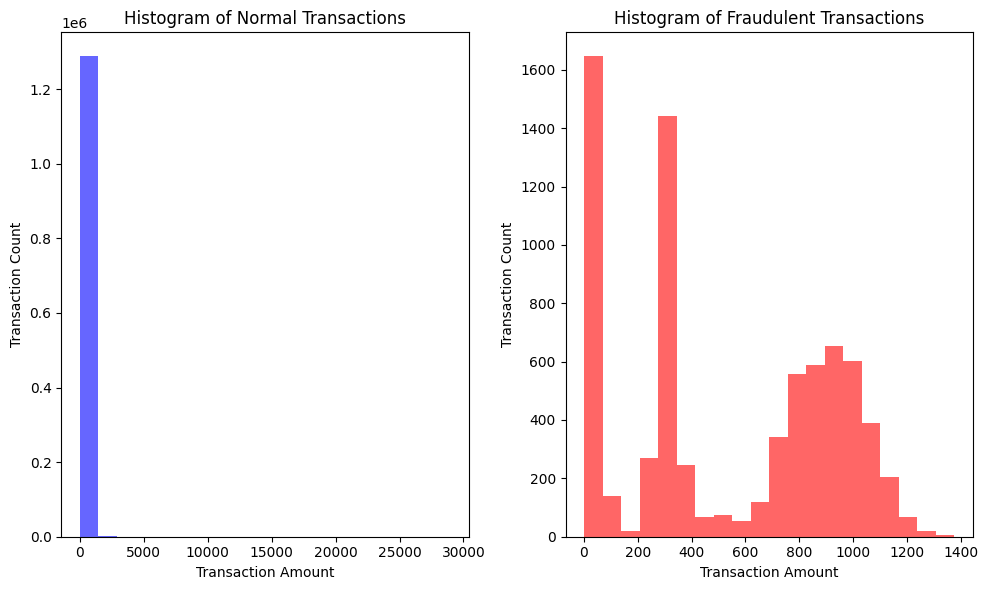

In [26]:
normal_transactions_amount = normal_transactions.select('amount').toPandas()
fraud_transactions_amount = fraud_transactions.select('amount').toPandas()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
ax[0].hist(normal_transactions_amount['amount'], bins=20, color='blue', alpha=0.6)
ax[0].set_title('Histogram of Normal Transactions')
ax[0].set_xlabel('Transaction Amount')
ax[0].set_ylabel('Transaction Count')

ax[1].hist(fraud_transactions_amount['amount'], bins=20, color='red', alpha=0.6)
ax[1].set_title('Histogram of Fraudulent Transactions')
ax[1].set_xlabel('Transaction Amount')
ax[1].set_ylabel('Transaction Count')

plt.tight_layout()
plt.show()

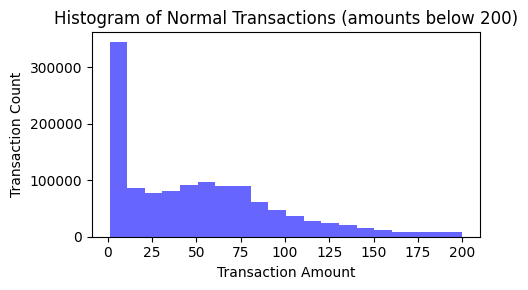

In [27]:
normal_transactions_amount_filtered = normal_transactions_amount[normal_transactions_amount['amount'] < 200]
fig, ax = plt.subplots(figsize=(5, 3))
ax.hist(normal_transactions_amount_filtered['amount'], bins=20, color='blue', alpha=0.6)
ax.set_title('Histogram of Normal Transactions (amounts below 200)')
ax.set_xlabel('Transaction Amount')
ax.set_ylabel('Transaction Count')
plt.tight_layout()
plt.show()


**Insight:** Frauduluent transactions have a smaller spread compared to the normal transcations; most of the normal transaction amounts are 200 and below.

## 5.3 How do the transactions differ in terms of transaction categories?

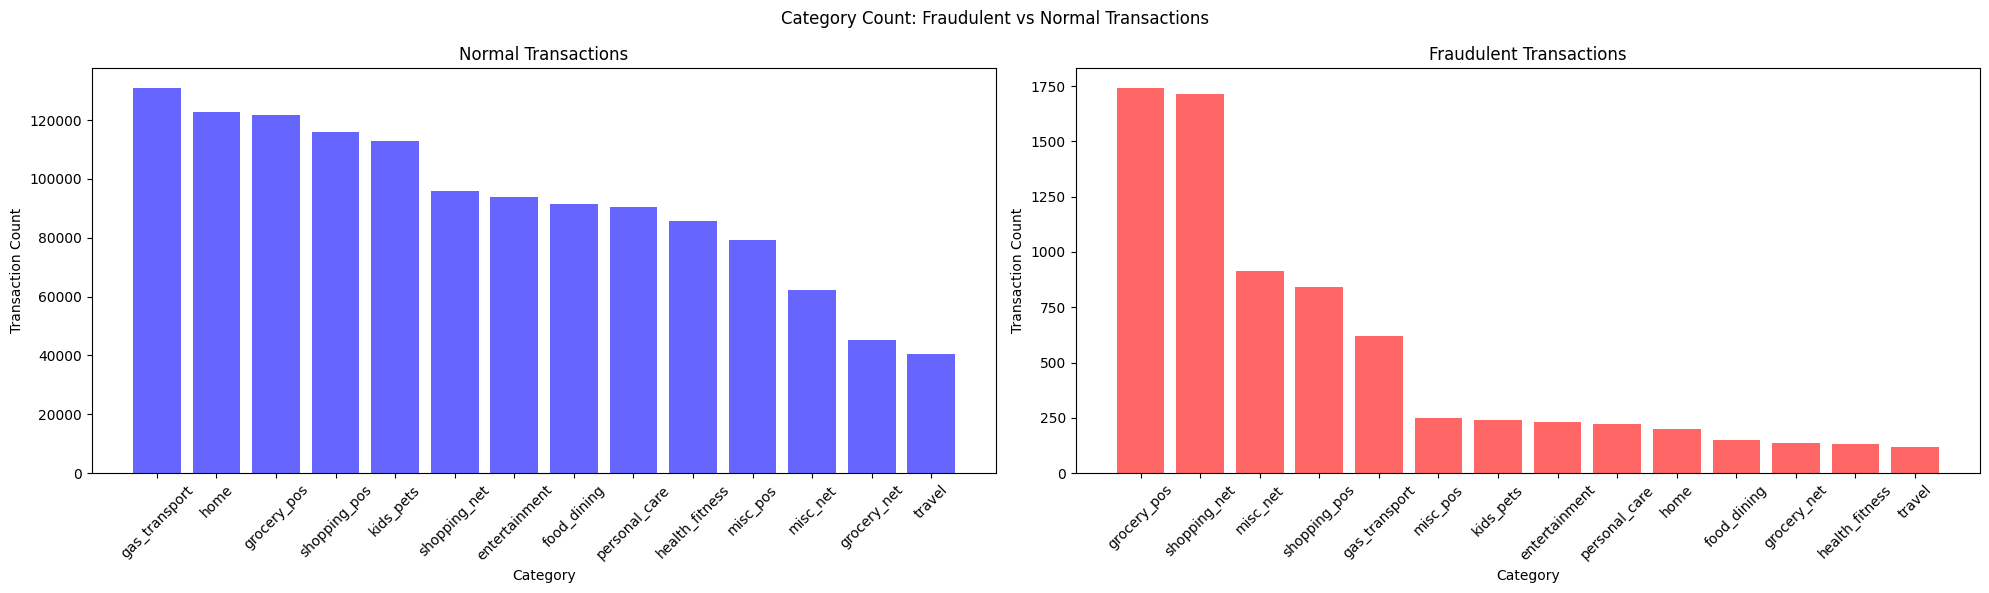

In [28]:
normal_transactions_categories = normal_transactions.groupby('category').agg(
    count('*').alias('transaction_count'),
    avg('amount').alias('average_amount')).orderBy(col('transaction_count').desc()).toPandas()

fraud_transactions_categories = fraud_transactions.groupby('category').agg(
    count('*').alias('transaction_count'),
    avg('amount').alias('average_amount')).orderBy(col('transaction_count').desc()).toPandas()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].bar(x=normal_transactions_categories['category'],
          height=normal_transactions_categories['transaction_count'], color='blue', alpha=0.6)
ax[0].set_title('Normal Transactions')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Transaction Count')
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(x=fraud_transactions_categories['category'],
          height=fraud_transactions_categories['transaction_count'], color='red', alpha=0.6)
ax[1].set_title('Fraudulent Transactions')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Transaction Count')
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle('Category Count: Fraudulent vs Normal Transactions')
plt.tight_layout()
plt.show()

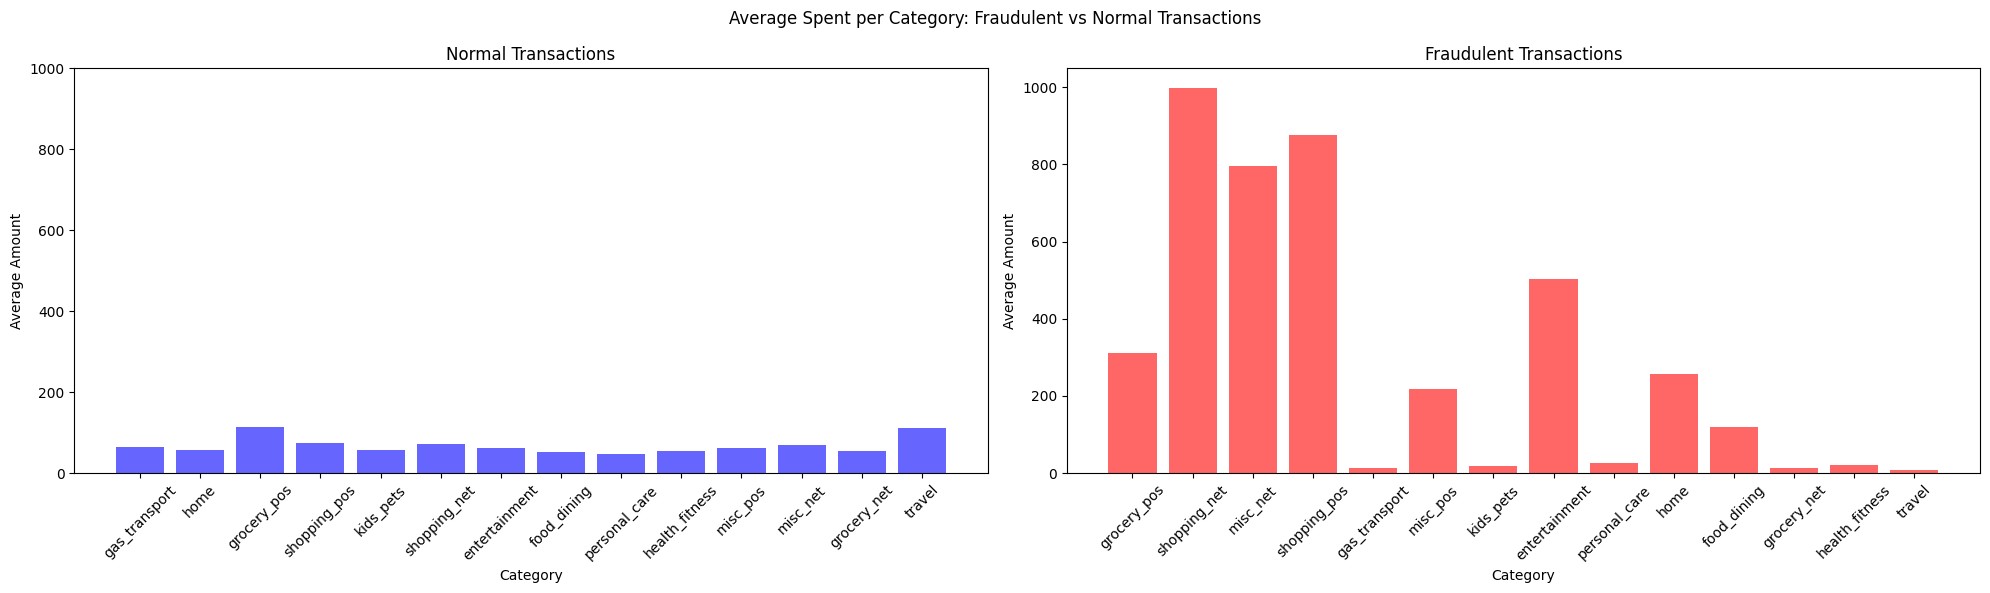

In [29]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].bar(x=normal_transactions_categories['category'],
          height=normal_transactions_categories['average_amount'], color='blue', alpha=0.6)
ax[0].set_title('Normal Transactions')
ax[0].set_xlabel('Category')
ax[0].set_ylabel('Average Amount')
ax[0].set_ylim(0, 1000)
ax[0].tick_params(axis='x', rotation=45)

ax[1].bar(x=fraud_transactions_categories['category'],
          height=fraud_transactions_categories['average_amount'], color='red', alpha=0.6)
ax[1].set_title('Fraudulent Transactions')
ax[1].set_xlabel('Category')
ax[1].set_ylabel('Average Amount')
ax[0].set_ylim(0, 1000)
ax[1].tick_params(axis='x', rotation=45)

plt.suptitle('Average Spent per Category: Fraudulent vs Normal Transactions')
plt.tight_layout()
plt.show()

**Insight:**
1. Frauduluent transactions are more concentrated on certain categories such as grocery_pos and shopping_net; normal transactions are more evenly spread out.
2. The average spent in each category is significantly different between normal and frauduluent transactions. A threshold could be set for each category to flag potential fraudulent transactions.

## 5.4 Do the transactions occur at certain time of the day?

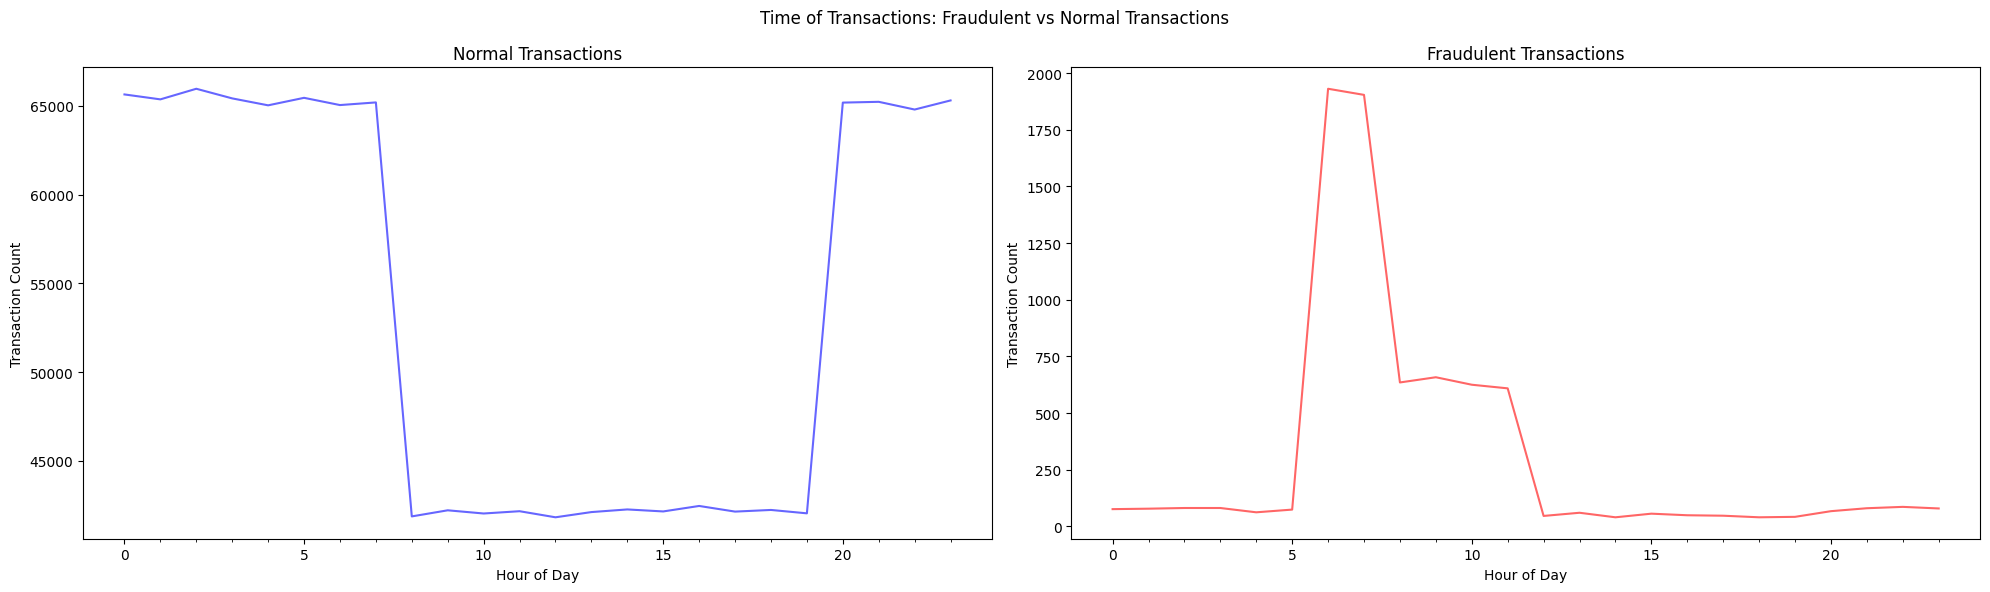

In [30]:
normal_transactions_hour = normal_transactions.withColumn('hour', hour('trans_time')) \
    .groupby('hour').count() \
    .orderBy(col('hour').asc()).toPandas()

fraud_transactions_hour = fraud_transactions.withColumn('hour', hour('trans_time')) \
    .groupby('hour').count() \
    .orderBy(col('hour').asc()).toPandas()

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
ax[0].plot(normal_transactions_hour['hour'],
           normal_transactions_hour['count'], color='blue', alpha=0.6)
ax[0].set_title('Normal Transactions')
ax[0].set_xlabel('Hour of Day')
ax[0].set_ylabel('Transaction Count')
ax[0].set_xticks(range(0, 24), minor=True)

ax[1].plot(fraud_transactions_hour['hour'],
           fraud_transactions_hour['count'], color='red', alpha=0.6)
ax[1].set_title('Fraudulent Transactions')
ax[1].set_xlabel('Hour of Day')
ax[1].set_ylabel('Transaction Count')
ax[1].set_xticks(range(0, 24), minor=True)

plt.suptitle('Time of Transactions: Fraudulent vs Normal Transactions')
plt.tight_layout()
plt.show()

**Insight:**
1. Most fradulent transactions occur between 6 am to 11 am.
2. Normal transactions usually occur between 8 pm to 7 am.
3. There are significantly less normal transactions between 8 am to 7 pm.

## 5.5 Are there credit cards that have only been used for fraudulent transactions?

In [72]:
fraud_cc = anonymised_cc_data.groupBy('cc_num').agg(
    max('is_fraud').alias('max_is_fraud'),
    min('is_fraud').alias('min_is_fraud')
)

blacklist_cc = fraud_cc.filter((col('max_is_fraud') == 1) & (col('min_is_fraud') == 1))
blacklist_cc = [row['cc_num'] for row in blacklist_cc.select('cc_num').distinct().collect()]
print(f'There are {len(blacklist_cc)} credit cards that have only been used for fraudulent transactions. These cards should be blacklisted.')
blacklist_cc[:5]

There are 75 credit cards that have only been used for fraudulent transactions. These cards should be blacklisted.


['00c57352e3e0aa713c62831f961ebbc0f60c5f87ce10fd8798216435349770e2',
 '07f120fb2b1d59ac4f216d75dc0b8296812a995f194ebddf78f737e14af732bc',
 '0b0e56b5bc3d2cff7dd4dac139784fdeaab498a7aedf2f560f6e72fe5dae6441',
 '0c7a5c1ad93beb20f402b71d40fc492ab4d4e9d6eb45adccdf783b139dec124b',
 '13af0da4e85d07af66468a217cea586000a808954f1055e0c513b706f7cc47b9']

[]

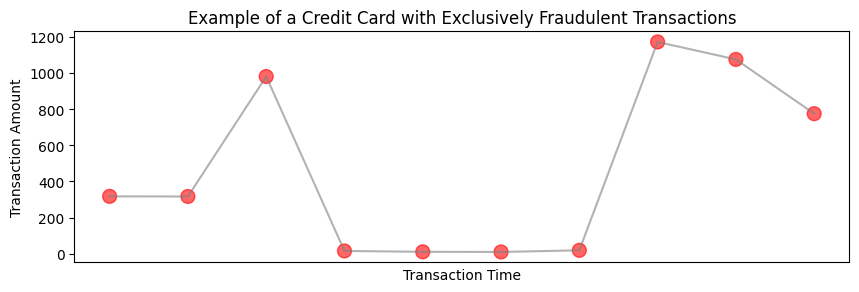

In [73]:
fig, ax = plt.subplots(figsize=(10, 3))
blacklist_cc_example = anonymised_cc_data.filter(col('cc_num') == blacklist_cc[0]).toPandas()
ax.plot(blacklist_cc_example['trans_time'], blacklist_cc_example['amount'], alpha=0.6, color='gray')
colours = list(blacklist_cc_example['is_fraud'].map({'0': 'blue', '1': 'red'}))
ax.scatter(blacklist_cc_example['trans_time'], blacklist_cc_example['amount'], alpha=0.6, color=colours, s=100)
ax.set_title('Example of a Credit Card with Exclusively Fraudulent Transactions')
ax.set_xlabel('Transaction Time')
ax.set_ylabel('Transaction Amount')
ax.set_xticks([])

**Insight:** There are 75 credit cards that should be blacklisted as they have only been used for fraudulent transactions.

## 5.6 Are there credit cards that have been compromised?

In [74]:
compormised_cc = fraud_cc.filter((col('max_is_fraud') == 1) & (col('min_is_fraud') == 0))
compormised_cc = [row['cc_num'] for row in compormised_cc.select('cc_num').distinct().collect()]
print(f'There are {len(compormised_cc)} credit cards that have been used for both normal and fraudulent transactions.')
compormised_cc[:5]

There are 687 credit cards that have been used for both normal and fraudulent transactions.


['008693edcf126fab9b566378897b3eb63eb40d71fa305b2a3922bdb32fb5ddb9',
 '00b9614bd546f3d62ddf828738b23bf72a29c09584915833c3b7dd2347e3d0d3',
 '00e1aeadc44e73d23f76008beeabd72dff0bb1a3eebcf8dbba5be6ba0f0e1bd4',
 '00e2ad8fed12b1ef527b71aa5edf6eb494901210121c09b349c1573b7ea4d177',
 '011df1128bb6b2e3894a4f7b84b70f64fda985037ae41c443f520ae93845935e']

[]

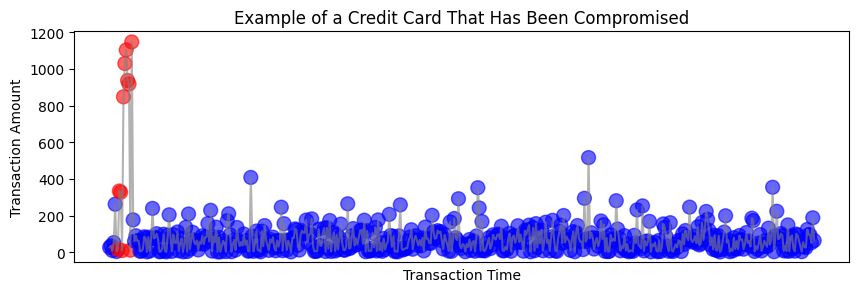

In [75]:
fig, ax = plt.subplots(figsize=(10, 3))
compormised_cc_example = anonymised_cc_data.filter(col('cc_num') == compormised_cc[2]).toPandas()
colours = list(compormised_cc_example['is_fraud'].map({'0': 'blue', '1': 'red'}))
ax.plot(compormised_cc_example['trans_time'], compormised_cc_example['amount'], alpha=0.6, color='gray')
ax.scatter(compormised_cc_example['trans_time'], compormised_cc_example['amount'], alpha=0.6, color=colours, s=100)
ax.set_title('Example of a Credit Card That Has Been Compromised')
ax.set_xlabel('Transaction Time')
ax.set_ylabel('Transaction Amount')
ax.set_xticks([])

In [81]:
compormised_cc_data = anonymised_cc_data.filter(col('cc_num').isin(compormised_cc))
compormised_cc_data.groupBy(['cc_num', 'is_fraud']).agg(
    avg(col('amount')).alias('average_amount')).orderBy(col('cc_num').asc(), col('is_fraud').asc()).show()

+--------------------+--------+------------------+
|              cc_num|is_fraud|    average_amount|
+--------------------+--------+------------------+
|008693edcf126fab9...|       0| 90.55759254136606|
|008693edcf126fab9...|       1| 350.6333352327347|
|00b9614bd546f3d62...|       0| 57.46256733320321|
|00b9614bd546f3d62...|       1| 425.8988854090373|
|00e1aeadc44e73d23...|       0| 70.92749504742021|
|00e1aeadc44e73d23...|       1|  607.614555272189|
|00e2ad8fed12b1ef5...|       0| 50.07973810781064|
|00e2ad8fed12b1ef5...|       1| 713.7213303883871|
|011df1128bb6b2e38...|       0|63.461909562114656|
|011df1128bb6b2e38...|       1| 627.7454528808594|
|0173389b22b35d28b...|       0| 66.63743545568174|
|0173389b22b35d28b...|       1| 550.1918192776767|
|019ce791d540b9e5a...|       0|62.022958782061465|
|019ce791d540b9e5a...|       1|  334.476425749915|
|01debd46ff3b91372...|       0|  83.7274118284774|
|01debd46ff3b91372...|       1|448.88285963875904|
|01f37b9a3b6b99203...|       0|

In [41]:
len(list(colours))

989

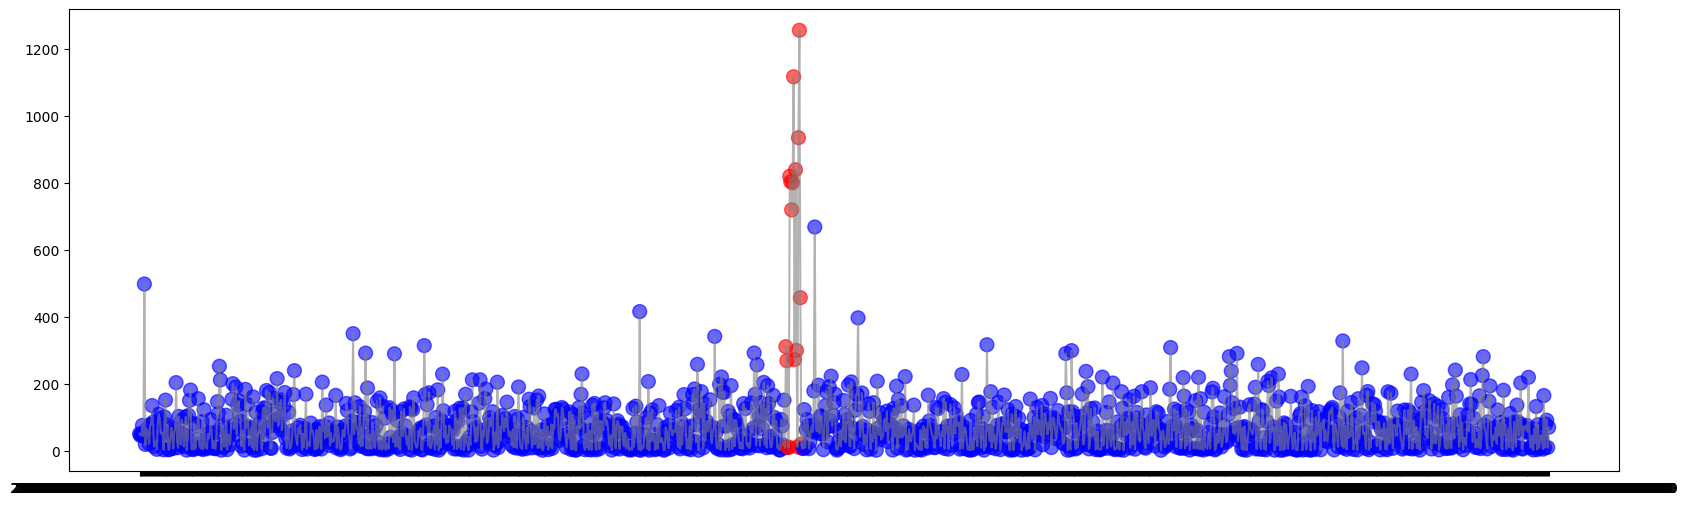